# Importing all dependencies

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import TensorDataset, DataLoader
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
import re
from tqdm import tqdm  # To show progress bar
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [3]:
# Load the dataset
column_names=["target","ids","date","flag","user","text"]
data = pd.read_csv('../Dataset/trainingset.csv', names=column_names, encoding='ISO-8859-1')
print(f"Data Shape: {data.shape}")

Data Shape: (1600000, 6)


In [26]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### making custom dataset from orignal dataset as dataset is too large and limited resources are there

In [4]:

# Sample 500 positive and 500 negative tweets
positive_tweets = data[data["target"] == 4][:]
negative_tweets = data[data["target"] == 0][:]
sampled_data = pd.concat([positive_tweets, negative_tweets])

### Checking for the null values

In [5]:
# Check for missing data
print(f"Missing Data: {sampled_data.isnull().sum()}")

Missing Data: target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


In [6]:
# Show some sample tweets
print(sampled_data.head())

        target         ids                          date      flag  \
800000       4  1467822272  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800001       4  1467822273  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800002       4  1467822283  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800003       4  1467822287  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800004       4  1467822293  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   

               user                                               text  
800000        ersle       I LOVE @Health4UandPets u guys r the best!!   
800001     becca210  im meeting up with one of my besties tonight! ...  
800002    Wingman29  @DaRealSunisaKim Thanks for the Twitter add, S...  
800003    katarinka  Being sick can be really cheap when it hurts t...  
800004  _EmilyYoung    @LovesBrooklyn2 he has that effect on everyone   


### Changing the value 4 to 1 for target posetive column and check for disribution of data 

In [7]:
# Preprocess target values
sampled_data.replace({'target': {4: 1}}, inplace=True)
print(f"Target Value Distribution: {sampled_data['target'].value_counts()}")

Target Value Distribution: target
1    800000
0    800000
Name: count, dtype: int64


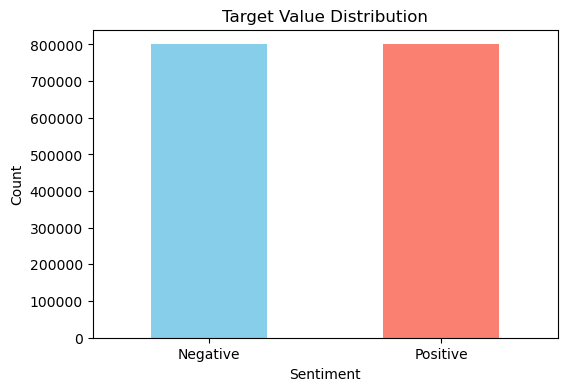

In [8]:
# Plotting the values to see visually
target_counts = sampled_data['target'].value_counts()

plt.figure(figsize=(6, 4))
target_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Value Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

# Stemming and cleaning data

- stemming basically refers to extract root values of the data

In [32]:
# Preprocess text by stemming and cleaning
stem = PorterStemmer()

def stemming(content):
    content = re.sub('[^a-zA-Z]', ' ', content)  # Remove non-alphabetic characters
    content = content.lower().split()  # Convert to lowercase and split into words
    content = [stem.stem(word) for word in content if word not in stopwords.words('english')]  # Stemming
    return ' '.join(content)

In [33]:
sampled_data["stemmed_contents"] = sampled_data['text'].apply(stemming)
print(f"Sampled Data after Preprocessing: {sampled_data.head()}")

Sampled Data after Preprocessing:         target         ids                          date      flag  \
800000       1  1467822272  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800001       1  1467822273  Mon Apr 06 22:22:45 PDT 2009  NO_QUERY   
800002       1  1467822283  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800003       1  1467822287  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   
800004       1  1467822293  Mon Apr 06 22:22:46 PDT 2009  NO_QUERY   

               user                                               text  \
800000        ersle       I LOVE @Health4UandPets u guys r the best!!    
800001     becca210  im meeting up with one of my besties tonight! ...   
800002    Wingman29  @DaRealSunisaKim Thanks for the Twitter add, S...   
800003    katarinka  Being sick can be really cheap when it hurts t...   
800004  _EmilyYoung    @LovesBrooklyn2 he has that effect on everyone    

                                         stemmed_contents  
800000                   love health uan

Splitting the training and testing data

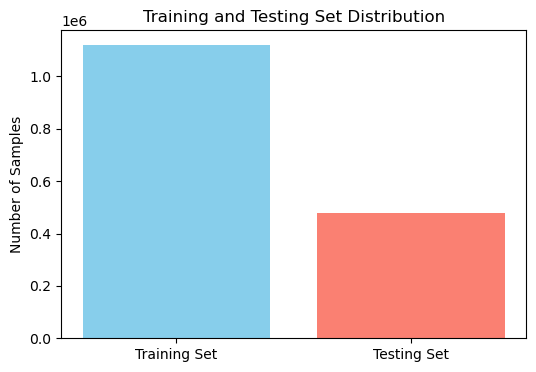

In [9]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(sampled_data, test_size=0.3, random_state=42)
# Plotting the training and testing set distribution
data_counts = [len(train_data), len(test_data)]
labels = ['Training Set', 'Testing Set']

plt.figure(figsize=(6, 4))
plt.bar(labels, data_counts, color=['skyblue', 'salmon'])
plt.title('Training and Testing Set Distribution')
plt.ylabel('Number of Samples')
plt.show()

# Loading tokenizer and model

In [35]:
# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize the training and testing data

In [36]:
# Tokenize the training and testing data
train_encodings = tokenizer(train_data["stemmed_contents"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_data["stemmed_contents"].tolist(), truncation=True, padding=True, max_length=128)

In [37]:
# Create PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings["input_ids"]), 
                               torch.tensor(train_encodings["attention_mask"]), 
                               torch.tensor(train_data["target"].values))

test_dataset = TensorDataset(torch.tensor(test_encodings["input_ids"]), 
                              torch.tensor(test_encodings["attention_mask"]), 
                              torch.tensor(test_data["target"].values))

In [38]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

### Define optimizer , loss function and early stopping parameters

In [39]:
# Define optimizer, loss function, and early stopping parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
patience = 2  # Early stopping patience
best_loss = np.inf
epochs = 10
counter = 0

# Training the model

In [40]:
# Train the model with progress bar and early stopping
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping triggered at Epoch {epoch+1}")
        break


Epoch 1/10 - Loss: 0.7054


Epoch 2/10 - Loss: 0.6612


Epoch 3/10 - Loss: 0.5010


Epoch 4/10 - Loss: 0.3026


Epoch 5/10 - Loss: 0.1454


Epoch 6/10 - Loss: 0.0771


Epoch 7/10 - Loss: 0.0488


Epoch 8/10 - Loss: 0.0316


Epoch 9/10 - Loss: 0.0216


Epoch 10/10 - Loss: 0.0213


# Save model and tokenizer

In [41]:

# Save the model and tokenizer
model.save_pretrained("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/added_tokens.json',
 './sentiment_model/tokenizer.json')

In [42]:
#save the optimizer and epoch for resuming training(In case we want to resume training)
torch.save(optimizer.state_dict(), "./sentiment_model/optimizer.pth")

# Model evalution

In [43]:
# Evaluate the model
model.eval()
predictions = []
true_labels = []

for batch in tqdm(test_loader, desc="Evaluating", leave=False):
    input_ids = batch[0]
    attention_mask = batch[1]
    labels = batch[2]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).tolist()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.tolist())

In [44]:
# Calculate accuracy and print classification report
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predictions))

Accuracy: 0.6867
              precision    recall  f1-score   support

           0       0.66      0.78      0.71       298
           1       0.73      0.60      0.66       302

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.68       600
weighted avg       0.69      0.69      0.68       600

